<div style='background: #FFE7DF; border-radius:10px; taxt-align: center; width: 444px; margin: 55px auto; padding:44px; border: 1px solid #754F4F'>
    <h5 style=' text-align:center; margin: auto'>
        Добрый день, выполним анализ опроса по рекламе 
    </h5>
</div>

In [1]:
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import *
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np
from sklearn.cluster import KMeans
#данная строчка нужна для корректного отображения графиков
%matplotlib inline 


In [2]:
df = pd.read_excel('ИССЛЕДОВАНИЕ ПОВЕДЕНИЯ (Ответы).xlsx')

###### преобразуем таблицу 

In [3]:
df.drop(['Отметка времени'], axis=1, inplace=True)

In [4]:
df.rename(columns = {'Выберете пол': 'Пол', 'Женат / замужем': 'Семья',
                    'Укажите ваш возраст': 'Возраст','Есть ли у вас дети?': 'Дети', 
                     'Выберете сферу вашей деятельности': 'Деятельность', 
                     'Оцените, как часто вы пользуетесь  социальными сетями?\nОтветы даются по пятибалльной шкале:\n1 – очень редко\n2 – иногда\n3 – часто\n4 – очень часто\n5 – практически не выхожу': 'Частота использования',
                     'Перейдёте по ссылке по рекомендации друзей/знакомых?': 'Переход по ссылке', 
                     'Сделаете репост по просьбе друзей/знакомых?': 'Репост по просьбе', 'Какие чувства вызовет такая реклама услуг?': 'Что вызывает реклама услуг', 'Какие чувства вызовет просьба сделать репост?': 'Чувства от просьбы'
                    }, inplace = True )

In [5]:
df.head(3)

,Пол,Возраст,Семья,Дети,Высшее образование,Деятельность,Частота использования,Переход по ссылке,Репост по просьбе,Что вызывает реклама услуг,Чувства от просьбы
0,Женский,28,Да,Нет,Да,"Производство, промышленность",2,Да,Нет,Интерес,Меня используют (манипуляция)
1,Мужской,34,Да,Да,Да,"Производство, промышленность",4,Да,Нет,Раздражение / агрессия,Стыд / неловкость / что подумают обо мне получ...
2,Женский,37,Нет,Нет,Да,Транспорт и логистика,3,Да,Да,Интерес,Первые 3 ответа в зависимости от уровня проект...


<div style=' background: #EDEDED; padding: 22px 24px;'>
    <p style=''><b>Частота использования социальных сетей</b></p>
    <ul style='list-style-type: none'>
    <li>1 - очень редко</li>
    <li>2 - иногда</li>
    <li>3 - часто</li>
    <li>4 - очень часто</li>
    <li>5 - практически не выхожу</li>
    </ul></div>

In [6]:
col=['Возраст', 'Частота использования'] # !!!!!! укажите количественные (int, float) столбцы, 
#                                       по которым выполним кластеризацию

In [7]:
pd.options.mode.chained_assignment = None 
df[col].fillna(0, inplace=True) # заменим пропуски данных нулями, в противном случае выдаст ошибку

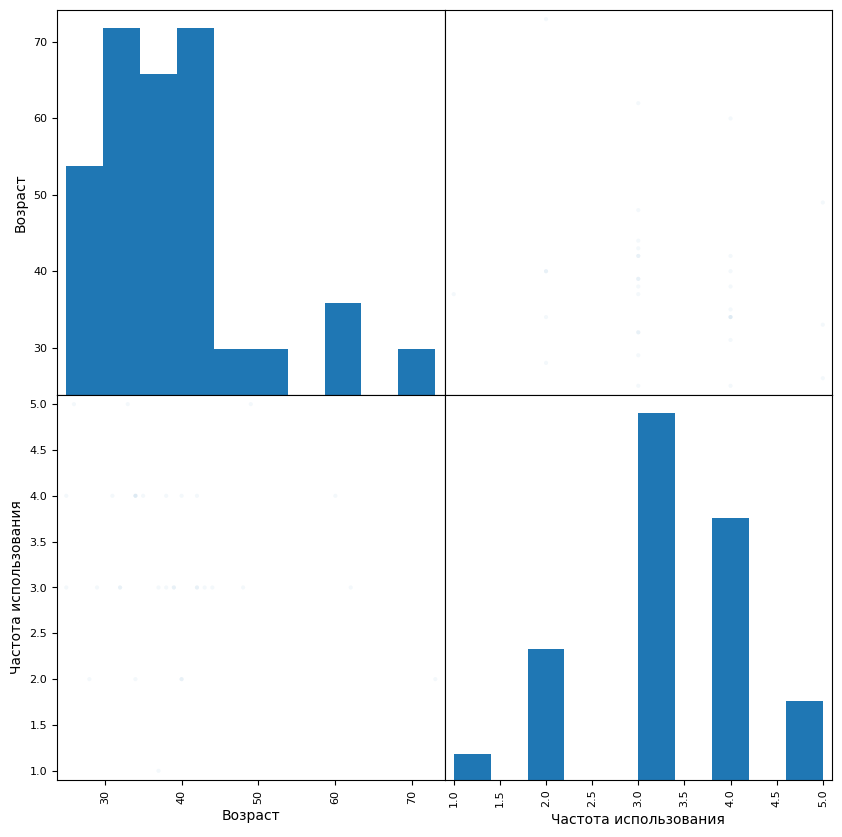

In [8]:
# матрица рассеяния и гистограммы
from pandas.plotting import scatter_matrix
scatter_matrix(df[col], alpha=0.05, figsize=(10, 10));


In [9]:
df[col].corr() # посмотрим на парные корреляции


,Возраст,Частота использования
Возраст,1.000000,-0.159993
Частота использования,-0.159993,1.000000


In [10]:
# загружаем библиотеку препроцесинга данных
# эта библиотека автоматически приведен данные к нормальным значениям
from sklearn import preprocessing
dataNorm = preprocessing.MinMaxScaler().fit_transform(df[col].values)


In [11]:
# Вычислим расстояния между каждым набором данных,
# т.е. строками массива data_for_clust
# Вычисляется евклидово расстояние (по умолчанию)
data_dist = pdist(dataNorm, 'euclidean')
# Главная функция иерархической кластеризии
# Объедение элементов в кластера и сохранение в 
# специальной переменной (используется ниже для визуализации 
# и выделения количества кластеров
data_linkage = linkage(data_dist, method='average')

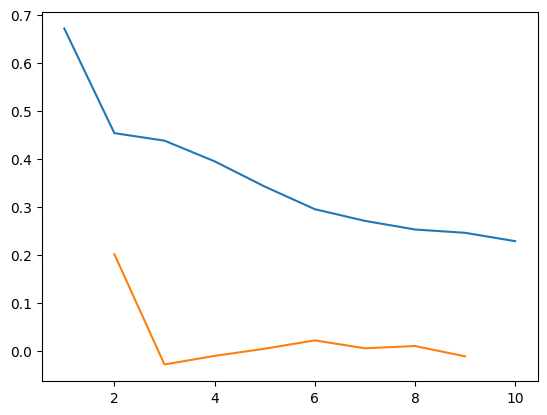

Рекомендованное количество кластеров: 2


In [12]:
# Метод локтя. Позволячет оценить оптимальное количество сегментов.
# Показывает сумму внутри групповых вариаций
last = data_linkage[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2 
print("Рекомендованное количество кластеров:", k)


In [13]:
#функция построения дендрограмм
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [14]:
# !!!!!!!!! укажите, какое количество кластеров будете использовать!
nClust=6

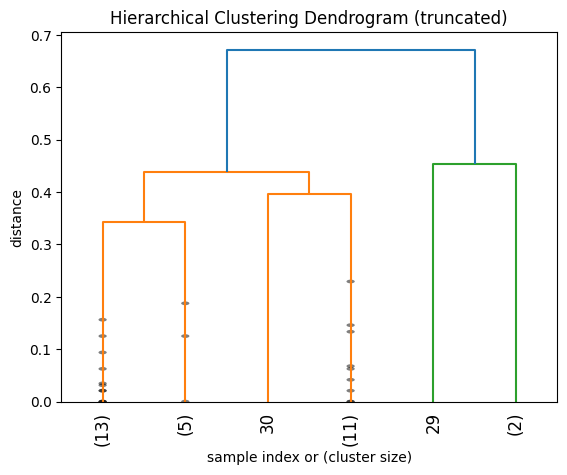

In [15]:
#строим дендрограмму 
fancy_dendrogram(
    data_linkage,
    truncate_mode='lastp',
    p=nClust, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
)
plt.show()

In [16]:
# иерархическая кластеризация
clusters=fcluster(data_linkage, nClust, criterion='maxclust')
clusters

array([2, 3, 1, 2, 2, 1, 2, 1, 1, 5, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 5,
       1, 1, 2, 3, 1, 1, 1, 6, 4, 1, 1], dtype=int32)

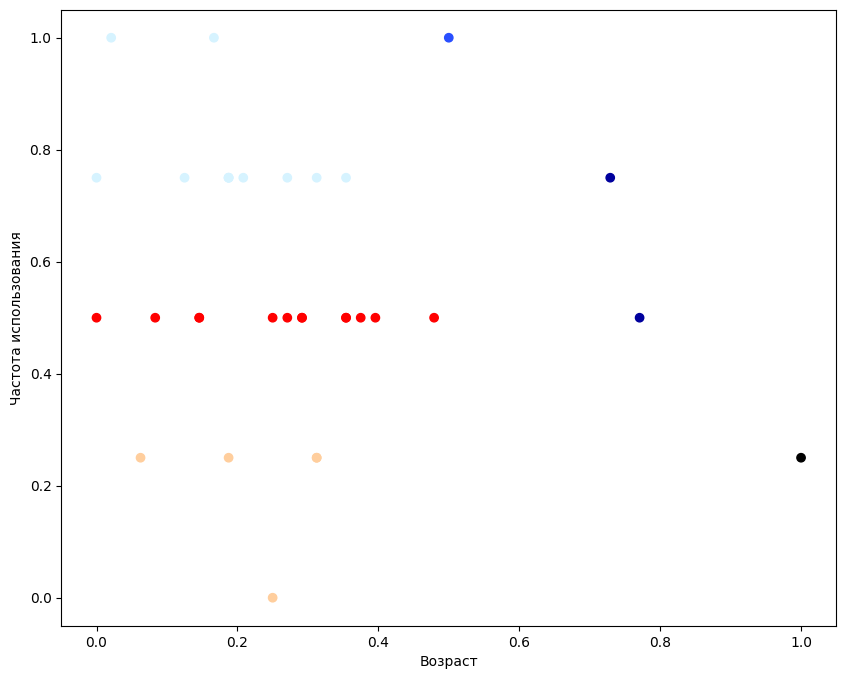

In [17]:
x=0 # Чтобы построить диаграмму в разных осях, меняйте номера столбцов
y=1 #
plt.figure(figsize=(10, 8))
plt.scatter(dataNorm[:,x], dataNorm[:,y], c=clusters, cmap='flag')
plt.xlabel(col[x])
plt.ylabel(col[y]);
plt.show()

In [18]:
# к оригинальным данным добавляем номер кластера
df['I']=clusters
res=df.groupby('I')[col].mean()
res['Количество']=df.groupby('I').size().values
res #ниже средние цифры по кластерам и количество объектов (Количество)

,Возраст,Частота использования,Количество
I,,,
1,37.692308,3.000000,13
2,35.800000,1.800000,5
3,33.818182,4.181818,11
4,49.000000,5.000000,1
5,61.000000,3.500000,2
6,73.000000,2.000000,1


In [19]:
df[df['I']==2] # !!!!! меняйте номер кластера

,Пол,Возраст,Семья,Дети,Высшее образование,Деятельность,Частота использования,Переход по ссылке,Репост по просьбе,Что вызывает реклама услуг,Чувства от просьбы,I
0,Женский,28,Да,Нет,Да,"Производство, промышленность",2,Да,Нет,Интерес,Меня используют (манипуляция),2
3,Женский,34,Да,Да,Да,Бухгалтерия / Финансы / Аудит / Страхование,2,Да,Да,Интерес,Желание помочь,2
4,Мужской,40,Да,Да,Да,Сфера образования,2,Да,Да,Интерес,Желание помочь,2
6,Мужской,37,Да,Да,Да,"Производство, промышленность",1,Да,Да,Интерес,Желание помочь,2
24,Женский,40,Да,Да,Да,"Производство, промышленность",2,Да,Нет,Меня используют (манипуляция),Желание помочь,2


In [20]:
# выводим только некоторые столбцы, меняйте список
df[df['I']==1][['Пол', 'Деятельность', 'Что вызывает реклама услуг']]


,Пол,Деятельность,Что вызывает реклама услуг
2,Женский,Транспорт и логистика,Интерес
5,Мужской,"Ритейл, ecommerce",Сдержанный интерес
7,Женский,проектирование в строительстве,Равнодушие
8,Мужской,Медицина и фармакология,Равнодушие
13,Женский,"Искусство и культура (кино, музыкальный бизнес...","Мне кажется, что блльшей части моих френдов эт..."
16,Женский,Организация спортивных мероприятий,Равнодушие
22,Женский,Сфера образования,Равнодушие
23,Женский,Бухгалтерия / Финансы / Аудит / Страхование,Интерес
26,Мужской,"Производство, промышленность",Раздражение / агрессия
27,Женский,"Менеджмент, администрирование",Интерес


In [21]:
# строим кластеризаци методом KMeans
km = KMeans(n_clusters=nClust).fit(dataNorm)

In [22]:
# выведем полученное распределение по кластерам
# так же номер кластера, к котрому относится строка, так как нумерация начинается с нуля, выводим добавляя 1
km.labels_ +1


array([4, 5, 1, 4, 4, 1, 4, 1, 1, 2, 5, 6, 5, 1, 5, 6, 1, 5, 5, 5, 5, 3,
       1, 1, 4, 5, 1, 1, 1, 3, 2, 1, 1], dtype=int32)

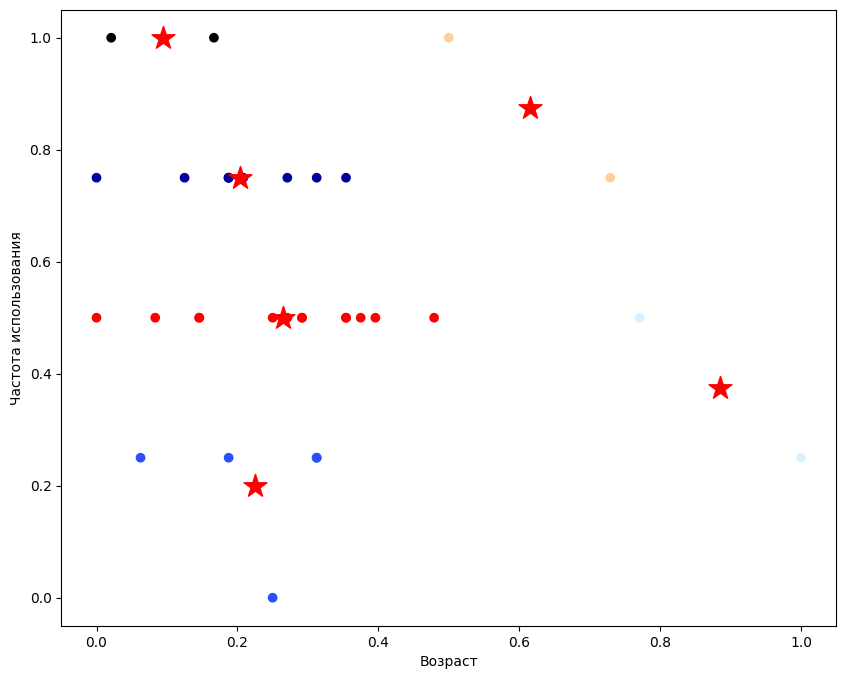

In [23]:
x=0 # Чтобы построить диаграмму в разных осях, меняйте номера столбцов
y=1 #
centroids = km.cluster_centers_
plt.figure(figsize=(10, 8))
plt.scatter(dataNorm[:,x], dataNorm[:,y], c=km.labels_, cmap='flag')
plt.scatter(centroids[:, x], centroids[:, y], marker='*', s=300,
            c='r', label='centroid')
plt.xlabel(col[x])
plt.ylabel(col[y]);
plt.show()

In [24]:
# к оригинальным данным добавляем номера кластеров
df['KMeans']=km.labels_+1
res=df.groupby('KMeans')[col].mean()
res['Количество']=df.groupby('KMeans').size().values
res

,Возраст,Частота использования,Количество
KMeans,,,
1,37.692308,3.0,13
2,54.500000,4.5,2
3,67.500000,2.5,2
4,35.800000,1.8,5
5,34.777778,4.0,9
6,29.500000,5.0,2


In [25]:
df[df['KMeans']==1] # изменяйте номер кластера, содержание которого хотите просмотреть

,Пол,Возраст,Семья,Дети,Высшее образование,Деятельность,Частота использования,Переход по ссылке,Репост по просьбе,Что вызывает реклама услуг,Чувства от просьбы,I,KMeans
2,Женский,37,Нет,Нет,Да,Транспорт и логистика,3,Да,Да,Интерес,Первые 3 ответа в зависимости от уровня проект...,1,1
5,Мужской,39,Нет,Да,Да,"Ритейл, ecommerce",3,Да,Нет,Сдержанный интерес,Равнодушие,1,1
7,Женский,39,Да,Нет,Да,проектирование в строительстве,3,Да,Нет,Равнодушие,Желание помочь,1,1
8,Мужской,25,Да,Нет,Да,Медицина и фармакология,3,Да,Да,Равнодушие,Желание помочь,1,1
13,Женский,44,Да,Да,Да,"Искусство и культура (кино, музыкальный бизнес...",3,Да,Да,"Мне кажется, что блльшей части моих френдов эт...",Желание помочь,1,1
16,Женский,43,Да,Да,Нет,Организация спортивных мероприятий,3,Да,Да,Равнодушие,Желание помочь,1,1
22,Женский,29,Да,Нет,Да,Сфера образования,3,Да,Нет,Равнодушие,Стыд / неловкость / что подумают обо мне получ...,1,1
23,Женский,38,Да,Да,Да,Бухгалтерия / Финансы / Аудит / Страхование,3,Да,Да,Интерес,Желание помочь,1,1
26,Мужской,32,Нет,Нет,Да,"Производство, промышленность",3,Нет,Нет,Раздражение / агрессия,Раздражение / агрессия,1,1
27,Женский,32,Да,Да,Да,"Менеджмент, администрирование",3,Да,Нет,Интерес,Стыд / неловкость / что подумают обо мне получ...,1,1


In [26]:
df[df['KMeans']==4][['Семья', 'Деятельность']]


,Семья,Деятельность
0,Да,"Производство, промышленность"
3,Да,Бухгалтерия / Финансы / Аудит / Страхование
4,Да,Сфера образования
6,Да,"Производство, промышленность"
24,Да,"Производство, промышленность"


In [27]:
# сохраним результаты в файл
# df.to_excel('result_claster.xlsx', index=False)

<div style='background: #FFE7DF; border-radius:10px; taxt-align: center; width: 444px; margin: 55px auto; padding:44px; border: 1px solid #754F4F'>
    <h5 style=' text-align:center; margin: auto'>
        итог
    </h5>
</div>